# TopoCluster Regression: IQR Comparison

In [1]:
# source & subdir -- used to specify a set of networks that were trained with particular data & settings
source = 'pion'
subdir = 'pion1'

#### 1) Initial setup

In [2]:
# Import some basic libraries.
import sys, os, glob, pathlib
import numpy as np
import h5py as h5
import ROOT as rt # used for plotting
from numba import jit
    
# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu

# regression-specific imports
from util.regression import plot_util as rpu

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = path_prefix + 'regression/Plots/{}/'.format(subdir)
modelpath = path_prefix + 'regression/Models/{}/'.format(subdir)
paths = [plotpath, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/00


#### 2) Get Results

Rather than get the data, networks & re-evaluate everything, we're just going to load network outputs from HDF5 files that were saved during training & evaluation in our training notebook. This means that this notebook should run rather quickly (and not require GPU resources for quick network evaluation). Just make sure not to throw out the HDF5 files with results, otherwise you will have to remake them with the other notebook.

In [3]:
# list of networks to evaluate
models = ['all','simple','simple_cnn','split_emb_cnn','resnet']
result_files = {
    model:{
        'pp':h5.File(modelpath + '{}/{}_charged_output.h5'.format(model,model),'r'),
        'p0':h5.File(modelpath + '{}/{}_neutral_output.h5'.format(model,model),'r'),
    }
    for model in models
}

results = {
    model:{
        key:{
            name:file[name][file['test'][:]]
            for name in ['output','truth','reco']
        }
        for key,file in result_files[model].items()
    }
    for model in models
}

for fdict in result_files.values():
    for key,val in fdict.items():
        val.close()

#### 3) Make IQR plots (with ROOT)

**TODO**: Try using some of our custom (matplotlib-based) functions. Maybe the plots will look nice?

In [17]:
nbins = 40
x_range = (0.,800.) # calib hits range

In [18]:
iqr_hists = {
    model:{
        key: rpu.IqrPlot(data['output'],data['truth'], nbins = nbins, x_range=x_range,normalize=True)
        for key,data in results[model].items()
    }
    for model in models
}

In [19]:
iqr_hists['reco'] = {
    key: rpu.IqrPlot(data['reco'],data['truth'], nbins = nbins, x_range=x_range,normalize=True)
    for key,data in results[models[0]].items()
}

In [20]:
plot_keys = ['reco'] + models
colors = [plotstyle.curve] +  [rt.kRed, rt.kYellow, plotstyle.main, rt.kGreen, rt.kViolet]

Info in <TCanvas::Print>: png file iqr_pp.png has been created
Info in <TCanvas::Print>: png file iqr_p0.png has been created


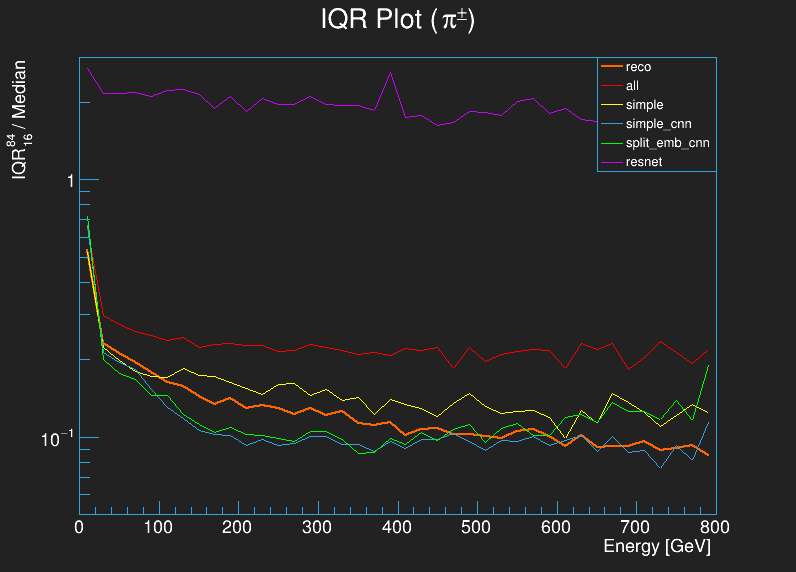

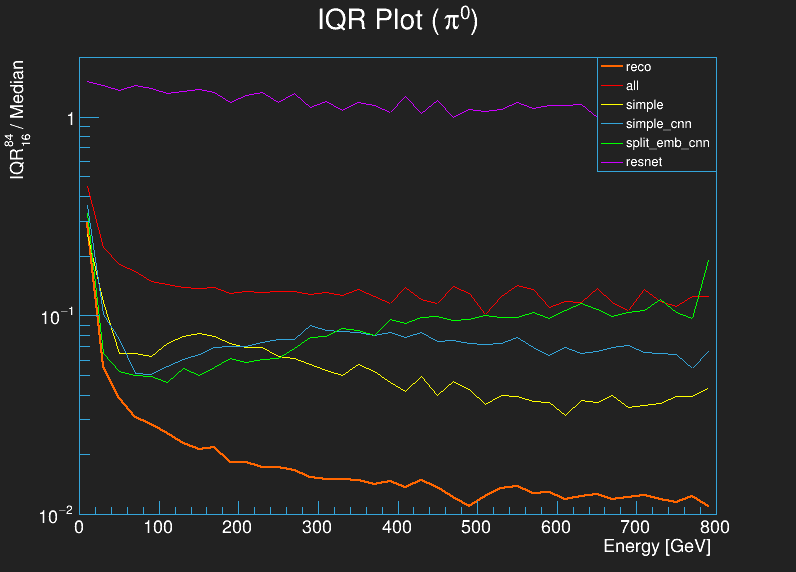

In [21]:
canvases = []
stacks = []
legends = []

pname = {
    'pp':'#pi^{#pm}',
    'p0':'#pi^{0}'
}

ranges = {
    'pp':(5.0e-2,3.),
    'p0':(1.0e-2,2.0)
}

for pkey in pname.keys():

    c = rt.TCanvas(qu.RN(),'c1',800,600)
    stack = rt.THStack()
    leg = rt.TLegend(0.75,0.7,0.9,0.9)
    leg.SetTextColor(plotstyle.text)

    for i,model in enumerate(plot_keys):
        iqr_hists[model][pkey].SetLineColor(colors[i])
        if(model == 'reco'): iqr_hists[model][pkey].SetLineWidth(2)
        stack.Add(iqr_hists[model][pkey])
        leg.AddEntry(iqr_hists[model][pkey],model,'l')

    stack.Draw('NOSTACK HIST L')
    
    stack.SetMinimum(ranges[pkey][0])
    stack.SetMaximum(ranges[pkey][1])

    rt.gPad.SetLogy()

    stack.SetTitle('IQR Plot ({});Energy [GeV];{}'.format(pname[pkey], 'IQR_{16}^{84} / Median'))
    leg.Draw()
    c.Draw()
    
    stacks.append(stack)
    canvases.append(c)
    legends.append(leg)
    c.SaveAs('iqr_{}.png'.format(pkey))